<a href="https://colab.research.google.com/github/davidsjohnson/wise24_xai_ac/blob/setup/notebooks/tutorial_audio_xai_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# uncomment and run this cell to use Google Colab
# !git clone https://github.com/davidsjohnson/wise24_xai_ac.git

In [4]:
import sys
import os
sys.path.append(os.path.realpath('../'))  # uncomment this line if you are running this notebook locally
# sys.path.append(os.path.realpath('wise24_xai_ac')) # uncomment this line if you are running this notebook on Google Colab

In [5]:
import os
from pathlib import Path
import random

from typing import Dict, List, Union, Any, Tuple, Iterable

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn

import librosa
import librosa.display

import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import Audio

import utils
import models
import evaluate

# Setup Dataset

## Download Data and Extract Features

In [6]:
ravdess_link = 'https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip?download=1'
data_dir = utils.download_file(url=ravdess_link,
                               file_name="ravdess.zip",
                               cache_dir= './data/ravdess',
                               extract=True,
                               force_download=False,
                               archive_folder='')
data_dir

File downloaded to: data/ravdess/ravdess.zip


PosixPath('data/ravdess')

In [7]:
basepath = Path('./output')

output_path = basepath / 'ravdess'
feature_path = output_path / 'features'
audio_path = output_path / 'audio_clips'
model_path = output_path /'model'

os.makedirs(feature_path, exist_ok=True)
os.makedirs(audio_path, exist_ok=True)

In [8]:
def get_log_melspec(data, sample_rate, silence_thresh=25):
  """
  Function for extracting features from an audio sample.  The audio is preprocess to remove silence and then
  padded on both sides to ensure each clip is 5 seconds.
  Then the log mel spectrogram is extracted.
  """
  trimmed, _ = librosa.effects.trim(data, top_db=silence_thresh)
  padded = np.pad(trimmed, (int(sample_rate*2.5-len(trimmed)//2), int(sample_rate*2.5-len(trimmed)//2)), 'constant')
  mel = librosa.feature.melspectrogram(y=padded, sr=sample_rate, n_fft=2048, hop_length=512, n_mels=128)
  return librosa.power_to_db(mel, ref=np.max)

In [9]:
LABEL_DICT = {0:'neutral', 1:'calm', 2:'happy', 3:'sad', 4:'angry', 5:'fear', 6:'disgust', 7:'surprise'}
LABEL_MAP_DICT = {v: k for k, v in LABEL_DICT.items()}
LABELS = list(LABEL_DICT.values())

In [10]:
data = dict(
    actor = [],
    emotion = [],
    intensity = [],
    gender = [],
    path = []
)

wav_files = data_dir.rglob('*.wav')

for wav in wav_files:

    _, _, emo, emo_int, _, _, actor = wav.stem.split('-')

    data['actor'].append(int(actor))
    data['emotion'].append(int(emo)-1)
    data['intensity'].append(int(emo_int))
    data['gender'].append('male' if int(actor) % 2 == 0 else 'female')
    data['path'].append(str(wav))

df_rav = pd.DataFrame.from_dict(data)
df_rav['emotion_label'] = df_rav.emotion.replace(LABEL_DICT, inplace=False)

# extract features and save to dataframe
def load_melspec(row):
  a, sr = librosa.load(row['path'], sr=16000)
  return get_log_melspec(a, sr, silence_thresh=55)

df_rav['spectro'] = df_rav.apply(load_melspec, axis=1)

In [11]:
# validate extracted features
for idx, row in df_rav.iterrows():
  assert row.spectro.shape == (128, 157), f'shape: {row.spectro.shape}'

## Review the Data

In [12]:
# review one row
audio_sample = df_rav.sample(1)
audio_sample

,actor,emotion,intensity,gender,path,emotion_label,spectro
916,24,5,1,male,data/ravdess/Actor_24/03-01-06-01-02-01-24.wav,fear,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8..."


In [13]:
# Display Audio to list to
Audio(audio_sample['path'].values[0])

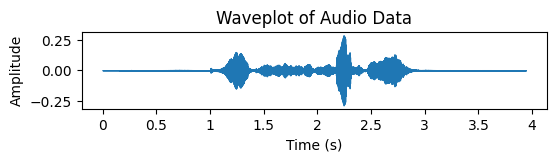

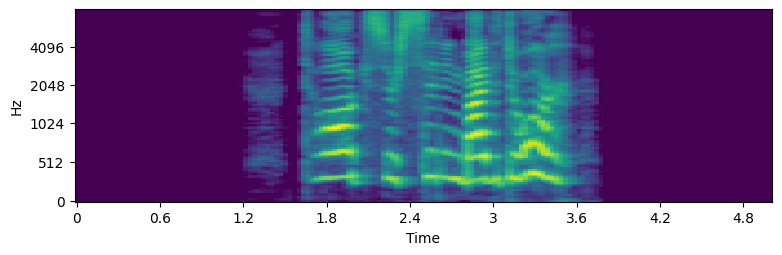

In [14]:
# load audio and downsample to 16000
y, sr = librosa.load(audio_sample['path'].values[0], sr=16000)

# Create wave plot
plt.figure(figsize=(6, 1))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveplot of Audio Data')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

plt.figure(figsize=(9,2.5))
librosa.display.specshow(audio_sample['spectro'].values[0],
                         sr=sr, hop_length=512, n_fft=2048,
                         x_axis='time', y_axis='mel',
                         cmap = 'viridis'
                         )
plt.show()

## Split Data

In [15]:
# # split dataset by actors
# all_actors = df_rav['actor'].unique()
# actors_gender = df_rav.groupby('actor')['gender'].unique().reset_index()

# train_actors, tmp = train_test_split(actors_gender, train_size=10, stratify=actors_gender['gender'], random_state=36851234)
# val_actors, test_actors = train_test_split(tmp, train_size=8, stratify=tmp['gender'], random_state=36851234)

# train_actors = train_actors['actor'].tolist()
# val_actors = val_actors['actor'].tolist()
# test_actors = test_actors['actor'].tolist()

# df_train = df_rav[df_rav['actor'].isin(train_actors)]
# df_val = df_rav[df_rav['actor'].isin(val_actors)]
# df_test = df_rav[df_rav['actor'].isin(test_actors)]

In [16]:
# Random data set split
df_train = df_rav.sample(frac=.8, random_state=0)
df_val = df_rav.drop(df_train.index).sample(frac=.5, random_state=0)
df_test = df_rav.drop(df_train.index).drop(df_val.index)

## Setup Pytorch Data Loaders

In [17]:
def get_dataset(df, feats_col, labels_col):
  labels = df[labels_col].values

  # convert from object array in dataframe to floats
  # and convert to numpy array
  feats = df[feats_col]
  feats = [f.astype(float) for f in feats]
  feats = np.array(feats)
  feats = feats[:, None, :, :]

  idxs = df.index.values

  # Setup features and labels as tensors
  X = torch.tensor(feats, dtype=torch.float32)
  y = torch.tensor(labels, dtype=torch.long)
  idxs = torch.tensor(idxs, dtype=torch.long)

  # Create TensorDataset
  dataset = TensorDataset(X, y, idxs)

  return dataset

In [18]:
# setup dataloaders based on previous dataset split
ds_train = get_dataset(df_train, 'spectro', 'emotion')
ds_val = get_dataset(df_val, 'spectro', 'emotion')
ds_test = get_dataset(df_test, 'spectro', 'emotion')

dl_train = DataLoader(ds_train, batch_size=64, shuffle=True)
dl_val = DataLoader(ds_val, batch_size=1, shuffle=False)
dl_test = DataLoader(ds_test, batch_size=1, shuffle=False)

# Load and Evaluate Pretrained Model

In [19]:
# get checkpoint
ckpt_link = 'https://uni-bielefeld.sciebo.de/s/eiOiBrhuOENmo0p/download'
ckpt_path = utils.download_file(ckpt_link,
                                'ravdess_model.pth',
                                cache_dir='./data/ravdess/model',
                                extract=False,
                                force_download=False
                                )
ckpt_path

File already exists at: data/ravdess/model/ravdess_model.pth


PosixPath('data/ravdess/model/ravdess_model.pth')

In [20]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Load and Evaluate Trained Model

In [21]:
# To load the best model:
model = models.ResNet(len(LABELS))
model.load_state_dict(torch.load(ckpt_path, map_location='cpu'))
model.to(device);

In [22]:
evaluate.evaluate_model(model, dl_train, criterion, device)
evaluate.evaluate_model(model, dl_val, criterion, device)
_, _, test_preds, test_probs = evaluate.evaluate_model(model, dl_test, criterion, device)

Evaluation Loss: 0.2378, Evaluation Accuracy: 0.9349
Evaluation Loss: 0.0925, Evaluation Accuracy: 0.9792
Evaluation Loss: 0.1880, Evaluation Accuracy: 0.9236


In [23]:
# load probabilities and predictions into dataframe for test dataset
df_test['pred'] = test_preds
df_test['prob'] = test_probs
test_corr = df_test['emotion'] == df_test['pred']
test_corr.astype(int).mean()

0.9236111111111112